# Sparkify Exploratory Data Analysis

This notebook contains an EDA of the Sparkify data with several purposes:
1. Understand the structure of the data
2. Clean and preprocess the dataset
3. Identify possible features for predicting churn

Please note that we will not work with the original Sparkify dataset (12GB) in this project but a medium-sizes subset (462MB). This is because I wanted to implement the Sparkify pipeline on Google Cloud Platform (GCP). The original dataset is stored on Amazon's S3 though and the way it is configured does not allow to easily transfer it to GCP. If so, the pipeline could easily be scaled up and re-executed with the original dataset.

When working with large datasets, it does in any case make sense to perform some EDA based on a smaller subset of the data.

## Requirements

1. The notebook must be executed from GCP so it can access Cloud Storage directly.
2. The notebook must be executed from a PySpark kernel.

## Content

This notebook contains the following steps:

1. [Load Data](#load-data)
2. [Exploratory Data Analysis](#explore)

In [1]:
project_dir = "/home/Sparkify-churn"
bucket_name = "pyspark-cluster-202205"
file_path = "data/medium_sparkify_event_data.json"

## Import Packages

In [2]:
from datetime import datetime
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf 
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

import os
os.chdir(project_dir)

%matplotlib inline

## Save Utility Fuctions

The following cell defines utility functions. The cell after saves them to `preprocessing_sparkify.py`. The utility functions can then be imported and reused in the churn prediction code.

In [3]:
def get_value_counts(df, column, n=20):
    """Returns the n top value counts of a Pyspark dataframe column."""
    return df.groupBy(column).count().orderBy("count", ascending=False).show(n, truncate=False)


def get_nunique(df, column):
    """Returns the number of unique values in a Pyspark dataframe column."""
    return df.groupBy(column).count().sort("count").count()


def get_unique(df, column, n=20):
    """Returns the sorted top n unique values in a Pyspark dataframe column."""
    return df.select(column).dropDuplicates().orderBy(column).show(n, truncate=False)


def dropna(df, column):
    """Removes missing and invalid records from a Pyspark dataframe."""
    df = df.filter((df[column].cast(StringType()) != "") & (df[column].isNotNull()))
    return df


def timestamp_to_date(df, column):
    """Assigns a new column 'date' from a timestamp column."""
    to_date = udf(lambda x: datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
    df = df.withColumn("date", to_date(df[column]))
    return df


def timestamp_to_weekday(df, column):
    """Assigns a new column 'weekday' from a timestamp column."""
    to_date = udf(lambda x: datetime.fromtimestamp(x / 1000).strftime("%A"))
    df = df.withColumn("weekday", to_date(df[column]))
    return df

def preprocess_sparkify_data(df):
    """Preprocesses the sparkify dataframe for predicting churn."""
    df = dropna(df, "userId")
    df = dropna(df, "sessionId")
    df = df.withColumn("churn", F.when(df["page"] == "Cancellation Confirmation", 1).otherwise(0))
    df = timestamp_to_date(df, column="ts")
    df = timestamp_to_weekday(df, column="ts")
    return df


In [4]:
%%writefile preprocessing_sparkify.py
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import udf 
from pyspark.sql.types import StringType


def get_value_counts(df, column, n=20):
    """Returns the n top value counts of a Pyspark dataframe column."""
    return df.groupBy(column).count().orderBy("count", ascending=False).show(n, truncate=False)


def get_nunique(df, column):
    """Returns the number of unique values in a Pyspark dataframe column."""
    return df.groupBy(column).count().sort("count").count()


def get_unique(df, column, n=20):
    """Returns the sorted top n unique values in a Pyspark dataframe column."""
    return df.select(column).dropDuplicates().orderBy(column).show(n, truncate=False)


def dropna(df, column):
    """Removes missing and invalid records from a Pyspark dataframe."""
    df = df.filter((df[column].cast(StringType()) != "") & (df[column].isNotNull()))
    return df


def timestamp_to_date(df, column):
    """Assigns a new column 'date' from a timestamp column."""
    to_date = udf(lambda x: datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
    df = df.withColumn("date", to_date(df[column]))
    return df


def timestamp_to_weekday(df, column):
    """Assigns a new column 'weekday' from a timestamp column."""
    to_date = udf(lambda x: datetime.fromtimestamp(x / 1000).strftime("%A"))
    df = df.withColumn("weekday", to_date(df[column]))
    return df

def preprocess_sparkify_data(df):
    """Preprocesses the sparkify dataframe for predicting churn."""
    df = dropna(df, "userId")
    df = dropna(df, "sessionId")
    df = df.withColumn("churn", F.when(df["page"] == "Cancellation Confirmation", 1).otherwise(0))
    df = timestamp_to_date(df, column="ts")
    df = timestamp_to_weekday(df, column="ts")
    return df


Overwriting preprocessing_sparkify.py


## 1. Load Data<a name="load-data"></a>

In [5]:
df = spark.read.json(f"gs://{bucket_name}/{file_path}")

## 2. Exploratory Data Analysis<a name="explore"></a>

### Data Overview

In [6]:
# number of events
df.count()

1087410

In [7]:
# columns
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# first two events
df.show(n=2, truncate=True, vertical=True)

-RECORD 0-----------------------------
 artist        | Martin Orford        
 auth          | Logged In            
 firstName     | Joseph               
 gender        | M                    
 itemInSession | 20                   
 lastName      | Morales              
 length        | 597.55057            
 level         | free                 
 location      | Corpus Christi, TX   
 method        | PUT                  
 page          | NextSong             
 registration  | 1532063507000        
 sessionId     | 292                  
 song          | Grand Designs        
 status        | 200                  
 ts            | 1538352011000        
 userAgent     | "Mozilla/5.0 (Mac... 
 userId        | 293                  
-RECORD 1-----------------------------
 artist        | John Brown's Body    
 auth          | Logged In            
 firstName     | Sawyer               
 gender        | M                    
 itemInSession | 74                   
 lastName      | Larson  

In [9]:
df = timestamp_to_date(df, column="ts")

In [10]:
df_evolution = (
    df
    .groupBy("date")
    .count()
    .orderBy("date")
    .toPandas()
)

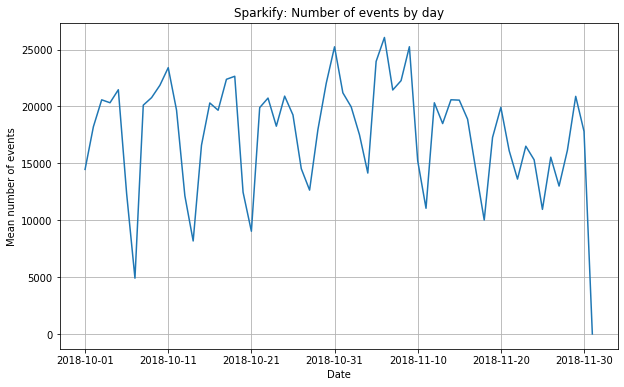

In [11]:
ax = df_evolution.plot(
    x="date",
    y="count",
    kind="line",
    figsize=(10, 6),
    title="Sparkify: Number of events by day",
    legend=False,
    color="#1f77b4",
    grid=True,
)
ax.set(xlabel="Date", ylabel="Mean number of events");

#### Summary
- The events were recorded between October 1, 2018 and November 30, 2018 (except for a few data points in early December 2018).

#### Motivation
- We should check for missing values in `page` and if necessary drop these records.
- There is no overall trend in the data.
- There is weekly seasonality: At the weekene, less events are tracked.

### Missing Values

a) `sessionId`

#### Motivation
- We should check for missing values in `sessionId` and if necessary drop these records.
- Non-identified sessions could be listed as `""` or `null` or anything.

In [12]:
get_value_counts(df, "sessionId", n=5)

+---------+-----+
|sessionId|count|
+---------+-----+
|1052     |2012 |
|2860     |1852 |
|3425     |1798 |
|4131     |1770 |
|477      |1674 |
+---------+-----+
only showing top 5 rows



In [13]:
# invalid data in sessionId
(df.filter((df["sessionId"] == "") | (df["sessionId"].isNull())).count())

0

#### Summary
- There are no sessions without a sessionId. ✔️

b) `userId`

#### Motivation
- We should check for missing values in `userId` and if necessary drop these records.
- Non-identified users could be listed as `""` or `null` or anything.

In [14]:
get_value_counts(df, "userId", n=5)

+------+-----+
|userId|count|
+------+-----+
|      |31400|
|92    |19534|
|140   |14896|
|300049|14618|
|101   |13684|
+------+-----+
only showing top 5 rows



In [15]:
# invalid data in sessionId
(df.filter((df["userId"] == "") | (df["userId"].isNull())).count())

31400

In [16]:
df = dropna(df, "userId")

In [17]:
# invalid data in sessionId
(df.filter((df["userId"] == "") | (df["userId"].isNull())).count())

0

#### Summary
- There were 31,400 records without `userId`.
- Those turn out to be unknown users which are just gathering information on the website, as the value counts show.
- Since they add no value to this analysis, they were dropped from the data. ✔️

c) `page`

#### Motivation
- We should check for missing values in `page` and if necessary drop these records.

In [18]:
get_value_counts(df, "page")

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |865754|
|Thumbs Up                |47652 |
|Home                     |38178 |
|Add to Playlist          |24698 |
|Add Friend               |16174 |
|Roll Advert              |15546 |
|Logout                   |11980 |
|Thumbs Down              |9822  |
|Downgrade                |7622  |
|Settings                 |5928  |
|Help                     |5288  |
|About                    |2052  |
|Upgrade                  |1936  |
|Save Settings            |1170  |
|Error                    |1006  |
|Submit Upgrade           |574   |
|Submit Downgrade         |234   |
|Cancel                   |198   |
|Cancellation Confirmation|198   |
+-------------------------+------+



#### Summary

- There are no records without a page. ✔️
- Pages correlated with customer activity could be:
    - 'Thumbs Up'
    - 'Add to Playlist'
    - 'Add Friend'
    - 'Upgrade'
    - 'Submit Upgrade'

### Definition of Churn

- After having done some preliminary analysis, a column `churn` to use as the label for the prediction model will be created.
- One option is using the `Cancellation Confirmation` events to define churn, which happen for both paid and free users.

In [19]:
df = df.withColumn("churn", F.when(df["page"] == "Cancellation Confirmation", 1).otherwise(0))

In [20]:
get_value_counts(df, "churn")

+-----+-------+
|churn|count  |
+-----+-------+
|0    |1055812|
|1    |198    |
+-----+-------+



In [21]:
get_nunique(df, "userId")

448

#### Summary
- The data seemed to be highly imbalanced first.
- However, the 1,056,010 Sparkify events come from only 448 unique users and 198 of them have churned.

### Data Visualization

This section is about performing data visualization, mainly with the goal to observe the behavior for users who stayed vs users who churned. The following hypotheses were used to steer data visualization below.

- The probability of churning could be lower for users which
    - have been using Sparkify longer,
    - are more active when they use Sparkify (like songs, add songs to playlists, add friends to Sparkify, etc.),
    - have never before visited the unsubscribe page,
    - have been observed in more unique sessions,
    - have had more overall interactions with Sparkify.
    
### Business Questions

3.1 What is the mean number of songs played by group?<br>
3.2 What is the mean number of events by group?<br>
3.3 When do users churn?<br>
3.4 Which share of events is GET vs. PUT?<br>

#### 1. What is the mean number of songs played by group?

Users who do not churn are expected to stream more songs from the Sparkify service. The mean number of songs played are thus expected to be different between customers who churn and customers who do not churn. 

In [22]:
df_user_info = (
    df.groupBy("userId")
    .agg({"churn": "max", "sessionId": "count", "song": "count"})
    .groupBy("max(churn)")
    .agg({"count(sessionId)": "mean", "count(song)": "mean"})
    .toDF("has_churned", "num_songs", "num_interactions")
    .toPandas()
)

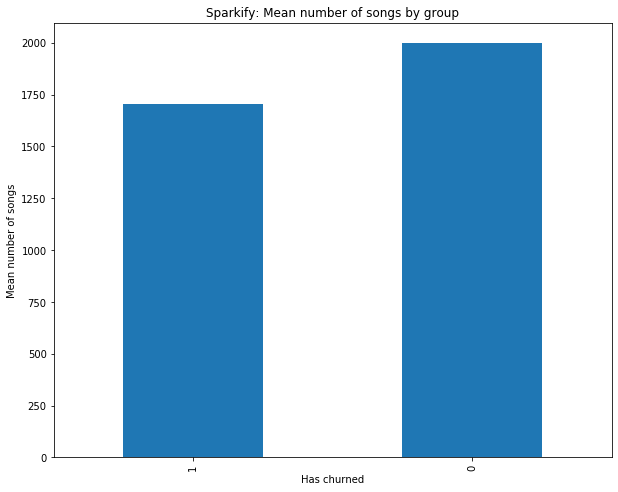

In [23]:
ax = df_user_info.plot(
    x="has_churned",
    y="num_songs",
    kind="bar",
    figsize=(10,8),
    title="Sparkify: Mean number of songs by group",
    legend=False,
    color="#1f77b4",
)
ax.set(xlabel="Has churned", ylabel="Mean number of songs");

#### Summary
- Users who churn have on average played less songs than users who do not churn (1,704 vs. 1,997).

#### 2. What is the mean number of events by group?

Similar to the mean number of songs played, users who do not churn are expected to show more general activity on the Sparkify platform. A similar pattern as shown above is expected with respect to the number of interactions.

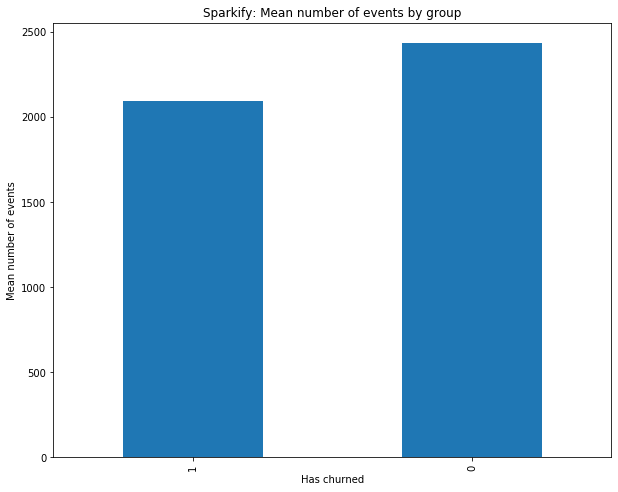

In [24]:
ax = df_user_info.plot(
    x="has_churned",
    y="num_interactions",
    kind="bar",
    figsize=(10,8),
    title="Sparkify: Mean number of events by group",
    legend=False,
    color="#1f77b4",
)
ax.set(xlabel="Has churned", ylabel="Mean number of events");

#### Summary
- Users who churn show less activity in total than users who do not churn (2,094 vs. 2,432).

#### 3. When do users churn?

#### Motivation

There may be a pattern in when users churn. Even though this is rather an external factor, it will help understanding business and churn preventions may be more intense on those days.

In [25]:
df = timestamp_to_weekday(df, column="ts")

In [26]:
df_churn_days = (
    df
    .groupBy("weekday")
    .agg({
        "churn": "sum",
        "sessionId": "count",
    })
    .toPandas()
)

In [27]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_churn_days = df_churn_days.set_index("weekday").loc[weekdays].reset_index()

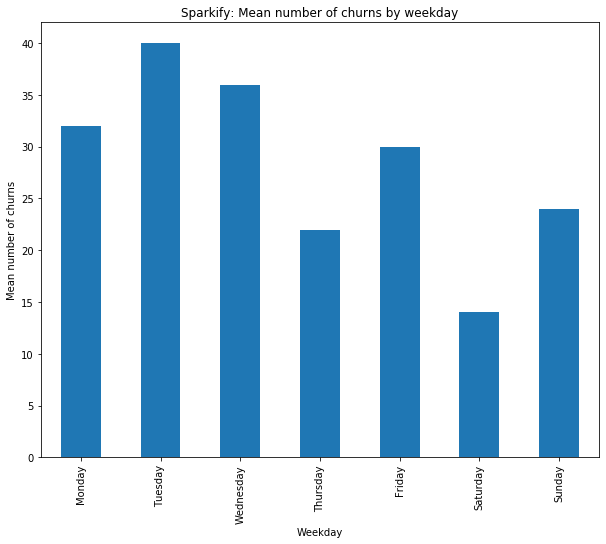

In [28]:
ax = df_churn_days.plot(
    x="weekday",
    y="sum(churn)",
    kind="bar",
    figsize=(10,8),
    title="Sparkify: Mean number of churns by weekday",
    legend=False,
    color="#1f77b4",
)
ax.set(xlabel="Weekday", ylabel="Mean number of churns");

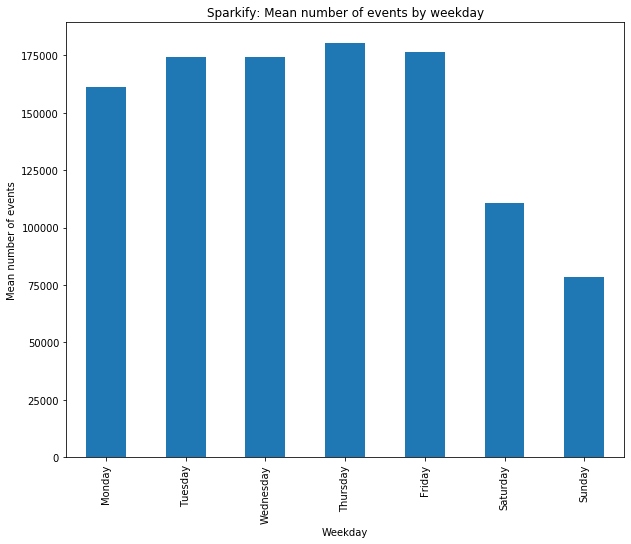

In [29]:
ax = df_churn_days.plot(
    x="weekday",
    y="count(sessionId)",
    kind="bar",
    figsize=(10,8),
    title="Sparkify: Mean number of events by weekday",
    legend=False,
    color="#1f77b4",
)
ax.set(xlabel="Weekday", ylabel="Mean number of events");

#### Summary
- There is not an obvious pattern depending on the weekday.
- Less people seem to churn at the weekend, but weekends are also least busy in terms of music streaming.

#### 4. Which share of events is GET vs. PUT?

#### Motivation

- PUT events may be related to a higher user activity. To see whether this could be a useful feature, understanding the share of PUT and GET events will be key.

In [30]:
df_method = (
    df
    .groupBy("method")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
)

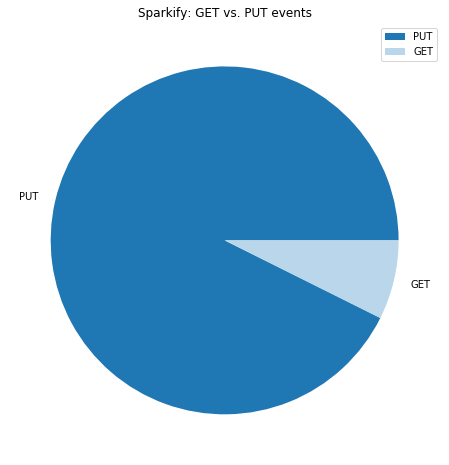

In [31]:
ax = df_method.set_index("method").plot(
    x="index",
    y="count",
    kind="pie",
    figsize=(8,8),
    title="Sparkify: GET vs. PUT events",
    legend=["PUT", "Get"],
    yticks=None,
    use_index=False,
    colors=["#1f77b4", "#bad6eb"],
)
ax.axis("off");

#### Summary

- While the majority of events are PUT - clicking on "Next Song" is accounts for most of the events, as shown above - 7.36% of the 1,056,010 events are GET features. This may influence whether or not users churn.